# Yahoo! Experiments

You can reproduce the experiments by loading the saved models or you can retrain the models by the provided code block at the end of this notebook. Now, let's reproduce the results for the Yahoo! dataset:

## Ranking Correlations

In [3]:
import pickle
import pandas as pd
from scipy.stats import kendalltau
from utils import natural_keys
from corrstats import dependent_corr


# load results
with open('./data/exp_open_yahoo.pkl', 'rb') as exp_file:
    res_open = pickle.load(exp_file)

with open('./data/exp_stra_yahoo.pkl', 'rb') as exp_file:
    res_stra = pickle.load(exp_file)

    
def get_metric_value(results, model_name, metric):

    for result in results:
        if result.model_name == model_name:
            return result.metric_avg_results[metric]

    
METRICS = sorted([m for m in res_open[0].metric_avg_results.keys() if '(s)' not in m], 
                 key=natural_keys)

MODELS  = [res.model_name for res in res_open]

df = pd.DataFrame(columns=['METRIC', 'CLOSED', 'IPS', 'UNBIASED', 'Q1', 'Q2'])

for idx, metric in enumerate(METRICS):

    ranking_open = []
    ranking_close = []
    ranking_ips = []
    ranking_snips = []
    ranking_unbiased = []
    ranking_q1 = []
    ranking_q2 = []
    
    for model in MODELS:
        ranking_open.append(get_metric_value(res_open, model, metric))
        ranking_close.append(get_metric_value([res_array[0] for res_array in res_stra], model, metric))
        ranking_ips.append(get_metric_value([res_array[1] for res_array in res_stra], model, metric))
        ranking_q1.append(get_metric_value([res_array[3] for res_array in res_stra], model, metric))
        ranking_q2.append(get_metric_value([res_array[4] for res_array in res_stra], model, metric))
        ranking_unbiased.append(get_metric_value([res_array[5] for res_array in res_stra], model, metric))


    # calculate Kendall tau
    tau_open_close, _ = kendalltau(ranking_open, ranking_close)
    tau_open_ips, _ = kendalltau(ranking_open, ranking_ips)
    tau_open_q1, _ = kendalltau(ranking_open, ranking_q1)
    tau_open_q2, _ = kendalltau(ranking_open, ranking_q2)
    tau_open_unbiased, _ = kendalltau(ranking_open, ranking_unbiased)

    # z is the baseline for significance tests
    z = ranking_close
    tau_unbiased_z, _ = kendalltau(ranking_unbiased, z)
    tau_closed_z, _ = kendalltau(ranking_close, z)
    tau_ips_z, _ = kendalltau(ranking_ips, z)
    tau_q1_z, _ = kendalltau(ranking_q1, z)
    tau_q2_z, _ = kendalltau(ranking_q2, z)

    # TODO: update xz param based on selected z baseline!
    _, p_close = dependent_corr(xy=tau_open_close, 
                                xz=tau_open_close, 
                                yz=tau_closed_z,
                                n=len(ranking_open))

    _, p_ips = dependent_corr(xy=tau_open_ips, 
                              xz=tau_open_close, 
                              yz=tau_ips_z,
                              n=len(ranking_open))

    _, p_unbiased = dependent_corr(xy=tau_open_unbiased, 
                                   xz=tau_open_close, 
                                   yz=tau_unbiased_z,
                                   n=len(ranking_open))

    _, p_q1 = dependent_corr(xy=tau_open_q1, 
                             xz=tau_open_close, 
                             yz=tau_q1_z,
                             n=len(ranking_open))

    _, p_q2 = dependent_corr(xy=tau_open_q2, 
                             xz=tau_open_close, 
                             yz=tau_q2_z,
                             n=len(ranking_open))

    df.loc[idx] = [metric, 
                   '%.3f (%.2f)' %(tau_open_close, p_close), 
                   '%.3f (%.2f)' %(tau_open_ips, p_ips),
                   '%.3f (%.2f)' %(tau_open_unbiased, p_unbiased),
                   '%.3f (%.2f)' %(tau_open_q1, p_q1), 
                   '%.3f (%.2f)' %(tau_open_q2, p_q2)]
    

display(df)

,METRIC,CLOSED,IPS,UNBIASED,Q1,Q2
0,MRR,0.582 (nan),0.582 (nan),0.642 (0.08),0.532 (0.23),0.388 (0.00)
1,NDCG@5,0.599 (nan),0.641 (0.11),0.700 (0.01),0.407 (0.01),0.414 (0.00)
2,NDCG@10,0.693 (0.50),0.704 (0.34),0.697 (0.45),0.559 (0.01),0.501 (0.00)
3,NDCG@20,0.729 (nan),0.721 (0.34),0.716 (0.33),0.636 (0.02),0.523 (0.00)
4,NDCG@30,0.652 (0.50),0.653 (0.49),0.713 (0.03),0.673 (0.33),0.450 (0.00)
5,NDCG@100,0.701 (nan),0.724 (0.13),0.774 (0.00),0.773 (0.03),0.348 (0.00)
6,NDCG@-1,0.622 (nan),0.644 (0.21),0.710 (0.00),0.722 (0.02),0.336 (0.00)
7,Precision@5,0.699 (0.50),0.558 (0.01),0.554 (0.00),0.276 (0.00),0.589 (0.02)
8,Precision@10,0.725 (nan),0.643 (0.02),0.650 (0.02),0.606 (0.00),0.564 (0.00)
9,Precision@20,0.720 (nan),0.600 (0.00),0.686 (0.08),0.666 (0.03),0.575 (0.01)


## Scatter plot

In [5]:
metric = 'NDCG@-1'

import pickle
import numpy as np
import pandas as pd
from scipy.stats import kendalltau
from utils import natural_keys
from corrstats import dependent_corr


# load results
with open('./data/exp_open_yahoo.pkl', 'rb') as exp_file:
    res_open = pickle.load(exp_file)

with open('./data/exp_stra_yahoo.pkl', 'rb') as exp_file:
    res_stra = pickle.load(exp_file)


def get_metric_value(results, model_name, metric):

    for result in results:
        if result.model_name == model_name:
            return result.metric_avg_results[metric]

MODELS  = [res.model_name for res in res_open]

ranking_open = []
ranking_close = []
ranking_ips = []
ranking_snips = []
ranking_q1 = []
ranking_q2 = []
ranking_groups = []

for model in MODELS:
    ranking_open.append(get_metric_value(res_open, model, metric))
    ranking_close.append(get_metric_value([res_array[0] for res_array in res_stra], model, metric))
    ranking_ips.append(get_metric_value([res_array[1] for res_array in res_stra], model, metric))
    ranking_q1.append(get_metric_value([res_array[3] for res_array in res_stra], model, metric))
    ranking_q2.append(get_metric_value([res_array[4] for res_array in res_stra], model, metric))
    ranking_unbiased.append(get_metric_value([res_array[5] for res_array in res_stra], model, metric))
    ranking_groups.append(model)

# map to numpy array
ranking_open = np.array(ranking_open, dtype=np.float)
ranking_close = np.array(ranking_close, dtype=np.float)
ranking_ips = np.array(ranking_ips, dtype=np.float)
ranking_unbiased = np.array(ranking_unbiased, dtype=np.float)
ranking_q1 = np.array(ranking_q1, dtype=np.float)
ranking_q2 = np.array(ranking_q2, dtype=np.float)

# remove all hyperparam numbers from the model name
def remove_digits(s):
    return ''.join([i for i in s if not i.isdigit()])

ranking_groups = [remove_digits(s) for s in ranking_groups]

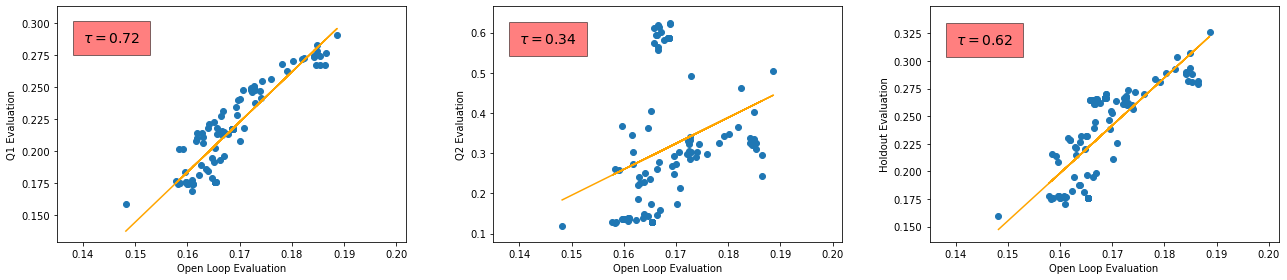

In [6]:
import matplotlib
# avoid type 3 fonts
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt


from scipy.stats import kendalltau

fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3)    
fig.set_figwidth(18)



cmap = plt.cm.Spectral
ax1.scatter(ranking_open, ranking_q1, label = ranking_groups)
# ax1.set_xlim([0,1])
# ax1.set_ylim([0,1])
ax1.set_xlabel('Open Loop Evaluation')
ax1.set_ylabel('Q1 Evaluation')
m, b = np.polyfit(ranking_open, ranking_q1, 1)
ax1.plot(ranking_open, m*ranking_open + b, color='orange')
tau_open_q1, _ = kendalltau(ranking_open, ranking_q1)
ax1.text(0.14, 0.285, r'$\tau=$'+ "%.2f" % tau_open_q1, fontsize=14, bbox={'facecolor':'red', 'alpha':0.5, 'pad':10})

ax2.scatter(ranking_open, ranking_q2, label = ranking_groups)
# ax2.set_ylim([0,1])
ax2.set_xlabel('Open Loop Evaluation')
ax2.set_ylabel('Q2 Evaluation')
m, b = np.polyfit(ranking_open, ranking_q2, 1)
ax2.plot(ranking_open, m*ranking_open + b, color='orange')
tau_open_q2, _ = kendalltau(ranking_open, ranking_q2)
ax2.text(0.14, 0.575, r'$\tau=$'+ "%.2f" % tau_open_q2, fontsize=14, bbox={'facecolor':'red', 'alpha':0.5, 'pad':10})


ax3.scatter(ranking_open, ranking_close, label = ranking_groups)
# ax3.set_ylim([0,1])
ax3.set_xlabel('Open Loop Evaluation')
ax3.set_ylabel('Holdout Evaluation')
m, b = np.polyfit(ranking_open, ranking_close, 1)
ax3.plot(ranking_open, m*ranking_open + b, color='orange')
tau_open_closed, _ = kendalltau(ranking_open, ranking_close)
ax3.text(0.14, 0.315, r'$\tau=$'+ "%.2f" % tau_open_closed, fontsize=14, bbox={'facecolor':'red', 'alpha':0.5, 'pad':10})



plt.tight_layout()
plt.subplots_adjust(wspace = 0.25)

plt.show() 

fig.savefig('scatter_yahoo.pdf', format='pdf');

## Compare all models

In [4]:
import pickle
import qgrid
import pandas as pd
from IPython.display import display
from scipy.stats import kendalltau, ttest_rel
from utils import natural_keys


# load results
with open('./data/exp_open_yahoo.pkl', 'rb') as exp_file:
    res_open = pickle.load(exp_file)

with open('./data/exp_stra_yahoo.pkl', 'rb') as exp_file:
    res_stra = pickle.load(exp_file)

    
def get_metric_value(results, model_name, metric, user_base=False):

    for result in results:
        if result.model_name == model_name:
            if user_base:
                return result.metric_user_results[metric]
            else:
                return result.metric_avg_results[metric]

    
METRICS = sorted([m for m in res_open[0].metric_avg_results.keys() if '(s)' not in m], 
                 key=natural_keys)

MODELS  = [res.model_name for res in res_open]


idx = 0

df = pd.DataFrame(columns=['METRIC', 'MODEL', 'OPEN', 'CLOSED', 'IPS', 'UNBIASED', 'Q1', 'Q2'])

for metric in METRICS:
        
    for model in MODELS:
        
        open_loop = get_metric_value(res_open, model, metric)
        closed = get_metric_value([res_array[0] for res_array in res_stra], model, metric)
        ips = get_metric_value([res_array[1] for res_array in res_stra], model, metric)
        q1 = get_metric_value([res_array[3] for res_array in res_stra], model, metric)
        q2 = get_metric_value([res_array[4] for res_array in res_stra], model, metric)
        unbiased = get_metric_value([res_array[5] for res_array in res_stra], model, metric)
        
        df.loc[idx] = [metric, model, 
                       '%.3f' %(open_loop),
                       '%.3f' %(closed), 
                       '%.3f' %(ips),
                       '%.3f' %(unbiased), 
                       '%.3f' %(q1), 
                       '%.3f' %(q2)]
        idx += 1
    


display(df[df.METRIC == 'NDCG@-1'])



,METRIC,MODEL,OPEN,CLOSED,IPS,UNBIASED,Q1,Q2
624,NDCG@-1,GA,0.148,0.160,0.144,0.156,0.159,0.120
625,NDCG@-1,MPOP,0.169,0.266,0.236,0.246,0.217,0.588
626,NDCG@-1,BaselineOnly,0.161,0.170,0.153,0.166,0.169,0.136
627,NDCG@-1,MLP,0.182,0.304,0.270,0.288,0.273,0.463
628,NDCG@-1,MF10,0.173,0.273,0.245,0.258,0.238,0.492
...,...,...,...,...,...,...,...,...
723,NDCG@-1,NeuMF60,0.169,0.247,0.221,0.237,0.234,0.268
724,NDCG@-1,NeuMF70,0.170,0.238,0.213,0.230,0.228,0.248
725,NDCG@-1,NeuMF80,0.165,0.232,0.207,0.224,0.223,0.236
726,NDCG@-1,NeuMF90,0.164,0.227,0.204,0.219,0.218,0.229


## Open Loop (Random) Evaluation

In [7]:
from cornac.eval_methods.base_method import BaseMethod
from cornac.experiment.experiment import Experiment

from utils import get_models, get_metrics
from datasets import yahoo_music, coats


# load the closed/open loop datasets
ds_closed = yahoo_music.load_feedback(variant='closed_loop')
ds_open = yahoo_music.load_feedback(variant='open_loop')


# train on closed-loop dataset and evaluate on open loop (random) dataset
eval_method = BaseMethod.from_splits(train_data=ds_closed, 
                                     test_data=ds_open, 
                                     rating_threshold=4.0,
                                     verbose=True)

# run the experiment: use variant='large' to produce for all models
exp_open = Experiment(eval_method=eval_method,
                      models=get_models(variant='small'),
                      metrics=get_metrics(variant='small'),
                      verbose=True)

exp_open.run()

rating_threshold = 4.0
exclude_unknowns = False
---
Training data:
Number of users = 15400
Number of items = 1000
Number of ratings = 311704
Max rating = 5.0
Min rating = 1.0
Global mean = 2.9
---
Test data:
Number of users = 5400
Number of items = 1000
Number of ratings = 54000
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 15400
Total items = 1000

[MPOP] Training started!

[MPOP] Evaluation started!


100%|██████████| 5400/5400 [00:03<00:00, 1572.91it/s]



[WMF32] Training started!


  2%|▏         | 100/5400 [00:00<00:05, 984.71it/s]


[WMF32] Evaluation started!


100%|██████████| 5400/5400 [00:06<00:00, 854.45it/s] 


TEST:
...
      | NDCG@-1 | NDCG@10 | NDCG@100 | NDCG@20 | NDCG@30 | NDCG@5 | Train (s) | Test (s)
----- + ------- + ------- + -------- + ------- + ------- + ------ + --------- + --------
MPOP  |  0.1685 |  0.0220 |   0.0610 |  0.0311 |  0.0387 | 0.0136 |    0.0124 |   3.4618
WMF32 |  0.1830 |  0.0292 |   0.0829 |  0.0429 |  0.0507 | 0.0200 |   41.3473 |   6.3317



## Propensity-based Stratified Evaluation

In [8]:
from datasets import yahoo_music, coats
from utils import get_models, get_metrics
from eval_methods.stratified_evaluation import StratifiedEvaluation
from experiment.experiment import STExperiment

# load the closed loop datasets
ds_closed = yahoo_music.load_feedback(variant='closed_loop')


stra_eval_method = StratifiedEvaluation(data=ds_closed,
                                        n_strata=2,
                                        rating_threshold=4.0,
                                        verbose=True)

# run the experiment: use variant='large' to produce for all models
exp_stra = STExperiment(eval_method=stra_eval_method,
                        models=get_models(variant='small'),
                        metrics=get_metrics(variant='small'),
                        verbose=True)

exp_stra.run()

rating_threshold = 4.0
exclude_unknowns = True


Calculating best minimal value for power law fit


Powerlaw exponential estimates: 2.347323, min=290
---
Training data:
Number of users = 15400
Number of items = 1000
Number of ratings = 249363
Max rating = 5.0
Min rating = 1.0
Global mean = 2.9
---
Test data (Q0):
Number of users = 14752
Number of items = 1000
Number of ratings = 62341
Max rating = 5.0
Min rating = 1.0
Global mean = 2.9
Number of unknown users = 0
Number of unknown items = 0


  0%|          | 0/14752 [00:00<?, ?it/s]

---
Test data (Q1):
Number of users = 14499
Number of items = 995
Number of ratings = 57560
Max rating = 5.0
Min rating = 1.0
Global mean = 2.9
Number of unknown users = 0
Number of unknown items = 0
---
Test data (Q2):
Number of users = 4095
Number of items = 5
Number of ratings = 4781
Max rating = 5.0
Min rating = 1.0
Global mean = 3.0
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 15400
Total items = 1000

[MPOP] Training started!

[MPOP] Evaluation started!


  1%|          | 100/14752 [00:00<00:22, 644.19it/s]


[MPOP] IPS Evaluation started!


  1%|          | 100/14752 [00:00<00:22, 637.74it/s]


[MPOP] SNIPS Evaluation started!


  1%|          | 100/14499 [00:00<00:15, 913.53it/s]


[MPOP] Stratified Evaluation started!


100%|██████████| 4095/4095 [00:02<00:00, 1453.51it/s]



[WMF32] Training started!


  0%|          | 0/14752 [00:00<?, ?it/s]


[WMF32] Evaluation started!


  0%|          | 0/14752 [00:00<?, ?it/s]


[WMF32] IPS Evaluation started!


  0%|          | 0/14752 [00:00<?, ?it/s]


[WMF32] SNIPS Evaluation started!


  1%|          | 100/14499 [00:00<00:25, 565.97it/s]


[WMF32] Stratified Evaluation started!


100%|██████████| 4095/4095 [00:05<00:00, 807.92it/s]


TEST:
...
[MPOP]
         |     NDCG@-1 |    NDCG@10 |    NDCG@100 |    NDCG@20 |     NDCG@30 |    NDCG@5 |       SIZE
-------- + ----------- + ---------- + ----------- + ---------- + ----------- + --------- + ----------
Closed   |      0.2648 |     0.0991 |      0.1970 |     0.1295 |      0.1499 |    0.0672 | 62341.0000
-------- + ----------- + ---------- + ----------- + ---------- + ----------- + --------- + ----------
IPS      |      0.2319 |     0.0808 |      0.1701 |     0.1113 |      0.1276 |    0.0581 | 62341.0000
SNIPS    | 489143.5631 | 57370.2216 | 364046.5564 | 63289.7067 | 211043.4839 | 5185.0747 | 62341.0000
-------- + ----------- + ---------- + ----------- + ---------- + ----------- + --------- + ----------
Q1       |      0.2164 |     0.0361 |      0.1431 |     0.0693 |      0.0917 |    0.0000 | 57560.0000
Q2       |      0.5900 |     0.5900 |      0.5900 |     0.5900 |      0.5900 |    0.5900 |  4781.0000
-------- + ----------- + ---------- + ----------- + ---------- +